**Lab: Model Order Selection for Neural Data**

Based on the polynomial model order selection demo. This lab covers representing neural time-series data in arrays, loading data from a pickle file, describing and fitting memoryless linear models,describing and fitting linear time-series models with delays, fitting linear models with multiple target outputs, selecting the optimal delay via cross-validation

**Loading the data**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix X is a matrix of spike counts where X [i, j] is the number of spikes from neuron j in time bin i. 

In [4]:
print(X.shape)
print(y.shape)

(61339, 52)
(61339, 2)


In [7]:
tsamp = 0.05  

nt = X.shape[0]
nneuron = X.shape[1]
nout = y.shape[1]
ttotal = tsamp*nt
print('nt = {}\nnneuron = {}\nnout = {}\nttotal = {}\n'.format(nt,nneuron,nout,ttotal))

nt = 61339
nneuron = 52
nout = 2
ttotal = 3066.9500000000003



**Fitting a Memoryless linear model**

Using simple linear regression to fit the data

In [8]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33)

In [9]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(Xtr,ytr)
yhat = regr.predict(Xts)
RSS_ts = np.mean((yts-yhat)**2)/(np.std(yts)**2)
rsq = 1-RSS_ts
print(rsq)

0.466330498633162


In [10]:
yhat.shape

(20242, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Actual')

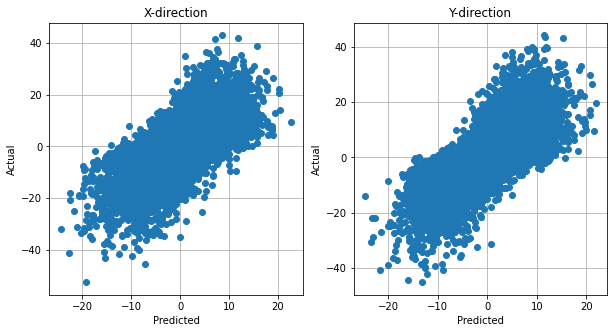

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("X-direction")
plt.plot(yhat[:,0], yts[:,0], 'o')
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("Y-direction")
plt.plot(yhat[:,1], yts[:,1],'o')
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')

**Fitting models with delay**

We can improve model accuracy by using delayed version of features wherein the output at time i+d depends on inputs at times i, i+1,...i+d

In [13]:
def create_dly_data(X,y,dly):
  
    Xdly = np.empty((X.shape[0]-dly,X.shape[1]*(dly+1)),int)
    ydly = np.zeros((y.shape[0]-dly,y.shape[1]))
    for i in range(0,y.shape[0]-dly):
      ydly[i,:] = y[i+dly,:] 
    
    for i in range(0,X.shape[0]-dly):
      delay = np.array([])
      for j in range(0,dly+1):
        delay = np.append(delay,X[i+j], axis = 0)
      Xdly[i] = delay
    
    return Xdly, ydly


In [14]:
Xdly,ydly=create_dly_data(X,y,dly=6)
Xtr, Xts, ytr, yts = train_test_split(Xdly, ydly, test_size=0.33)
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(Xtr,ytr)
yhat = regr.predict(Xts)
RSS_ts = np.mean((yts-yhat)**2)/(np.std(yts)**2)
rsq = 1-RSS_ts
print(rsq)

0.6893795749818847


Plotting predicted v/s true values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'actual')

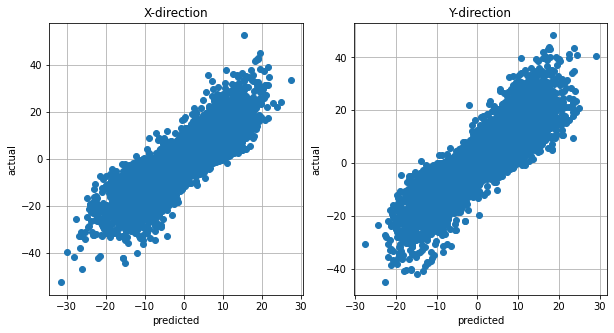

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("X-direction")
plt.plot(yhat[:,0], yts[:,0], 'o')
plt.grid()
plt.xlabel('predicted')
plt.ylabel("actual")

plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("Y-direction")
plt.plot(yhat[:,1], yts[:,1],'o')
plt.grid()
plt.xlabel("predicted")
plt.ylabel("actual")

**Selecting the optimal delay via Model Order Selection**

Limiting data samples as taking all samples is computationally exhaustive

In [16]:
nred = 6000

Xred = X[:nred,:]
yred = y[:nred,:]

In [17]:
import numpy.polynomial.polynomial as poly 
import  sklearn.model_selection 
import tqdm.notebook

nfold = 5  # Number of folds
dmax = 15  # maximum number of delays

Create a k-fold object
kf = sklearn.model_selection.KFold(n_splits=nfold, shuffle=True)

#Model orders to be tested
dtest = np.arange(0,dmax)  
nd = len(dtest)
regr_Kfold = LinearRegression()
  
# Initialize a matrix Rsq to hold values of the R^2 across the model orders and folds.
# Alternatively, you can also create an RSS matrix
Rsq = np.zeros((nd,nfold))
RSSts = np.zeros((nd, nfold))

# Create a progress bar.  Note there are nd*nfold total fits.
pbar = tqdm.notebook.tqdm(total=nfold*nd, initial=0,
    unit='fits', unit_divisor=nd, desc='Model order test')


for it, d in enumerate(dtest): 
    # Create the delayed data using the create_dly_function from the reduced
    # data Xred, yred
    Xdly, ydly = create_dly_data(Xred, yred, d)    

    # Loop over the folds
    for isplit, Ind in enumerate(kf.split(Xdly)):
  
        # Get the training data in the split
        Itr, Its = Ind        

        # Split the data (Xdly,ydly) into training and test
        Xtr = Xdly[Itr]
        ytr = ydly[Itr]
        Xts = Xdly[Its]
        yts = ydly[Its]

        Fit data on training data        
        
        regr_Kfold.fit(Xtr,ytr)

        Measure the R^2 vale on test data and store in the matrix Rsq
        yhat2 = regr_Kfold.predict(Xts)
        Rsq[it,isplit] = r2_score(yts,yhat2)
        RSSts[it,isplit] = np.mean((yts - yhat2)**2)
        pbar.update(1)
pbar.close()              

Computing mean and standard error

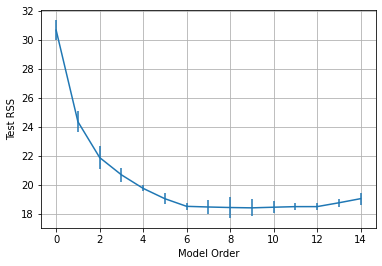

In [18]:
RSS_mean = np.mean(RSSts, axis=1)
RSS_std = np.std(RSSts,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.xlabel('Model Order')
plt.ylabel('Test RSS')
plt.grid()
plt.show()

Finding optimal order with normal rule, i.e. R^2

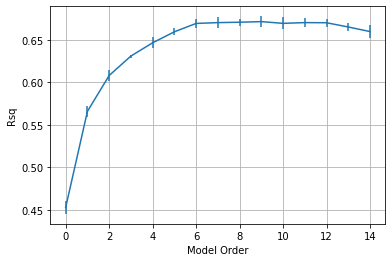

In [20]:
Rsq_mean = np.mean(Rsq, axis=1)
Rsq_std = np.std(Rsq,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, Rsq_mean, yerr=Rsq_std, fmt='-')
plt.xlabel('Model Order')
plt.ylabel('Rsq')
plt.grid()
plt.show()

In [21]:
Min_Order = np.argmax(Rsq_mean)
print("The selected model order is {}".format(dtest[Min_Order]))

The selected model order is 9


Finding optimal model order with one SE rule

The optimal model order is 9


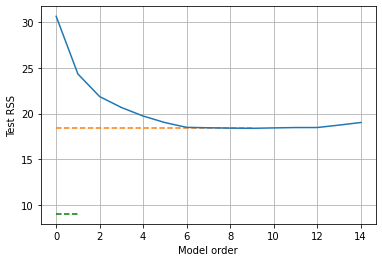

In [22]:
RSS_target = RSS_mean[Min_Order] + RSS_std[Min_Order]

I = np.where(RSS_mean<=RSS_target)[0]
iopt = I[0]
d_optimal = dtest[iopt]

plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.plot([dtest[0], dtest[Min_Order]], [RSS_target, RSS_target], '--')
plt.plot([d_optimal, d_optimal],'g--')
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

print("The optimal model order is {}".format(d_optimal))